## Step 4: Develop a neural network model

**Project**: Predicting Bus Ridership \
**Team**: T20 - Eurus Li, Garrett Kent, Kate Munkacsy

### A. Initial setup

In [33]:
## UPDATE BEFORE RUNNING CODE
dir = "path/to/repo/"

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import copy
import torch
import torch.nn as nn

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

## package to help with group-based time series test-train splits
## source: https://rasbt.github.io/mlxtend/user_guide/evaluate/GroupTimeSeriesSplit/
from mlxtend.evaluate.time_series import GroupTimeSeriesSplit, plot_splits

### B. Import feature data

In [36]:
data = pd.read_csv(dir + "/Data/feature_matrix.csv")
data.head()

,route,current_garage,day_type,lagged_total_precip,lagged_avg_temp,year,month,lagged_avg_riders,season,num_unique_stops,num_unique_stops_with_shelter,covid,avg_riders
0,1,Ross,SAT.,3.43,33.6,2017,1,NaN,Winter,224.0,17.0,0,969.50
1,1,Ross,SAT.,3.54,34.6,2017,2,969.50,Winter,224.0,17.0,0,1238.75
2,1,Ross,SAT.,1.46,40.6,2017,3,1238.75,Spring,224.0,17.0,0,1178.25
3,1,Ross,SAT.,5.02,39.9,2017,4,1178.25,Spring,224.0,17.0,0,1285.20
4,1,Ross,SAT.,3.54,57.3,2017,5,1285.20,Spring,224.0,17.0,0,1235.50


### C. Prepare date chunking for train-test splits

In [38]:
## Create date column for indexing
data['date'] = data['year'].astype(str) + '-' + data['month'].astype(str).str.pad(2, 'left', '0')

## Sort by date
df_sorted = data.sort_values('date')
df_sorted = df_sorted.set_index('date')
df_sorted.head()

,route,current_garage,day_type,lagged_total_precip,lagged_avg_temp,year,month,lagged_avg_riders,season,num_unique_stops,num_unique_stops_with_shelter,covid,avg_riders
date,,,,,,,,,,,,,
2017-01,1,Ross,SAT.,3.43,33.6,2017,1,NaN,Winter,224.0,17.0,0,969.500000
2017-01,74,East Liberty,SAT.,3.43,33.6,2017,1,NaN,Winter,177.0,6.0,0,392.000000
2017-01,74,East Liberty,WEEKDAY,3.43,33.6,2017,1,NaN,Winter,177.0,6.0,0,874.590909
2017-01,75,East Liberty,SAT.,3.43,33.6,2017,1,NaN,Winter,157.0,13.0,0,1783.500000
2017-01,75,East Liberty,SUN.,3.43,33.6,2017,1,NaN,Winter,157.0,13.0,0,1111.200000


In [39]:
## specify chunks for time series splits
cv_args = {"test_size": 1, "n_splits": 10}
tscv = GroupTimeSeriesSplit(**cv_args)
months = np.sort(df_sorted.index)
months

array(['2017-01', '2017-01', '2017-01', ..., '2024-10', '2024-10',
       '2024-10'], dtype=object)

In [40]:
unique_months = np.unique(months)
month_to_group = {month: idx for idx, month in enumerate(unique_months)}
groups = np.array([month_to_group[m] for m in months])

### D. Establish feature and outcome dataframes

In [42]:
## establish feature and target dataframes
X = df_sorted.drop(['avg_riders'], axis = 1)
y = df_sorted['avg_riders']

## drop sparse columns
sparse_columns = list(X.columns[X.nunique() / len(X) * 100 < 0.01])
X = X.drop(sparse_columns, axis = 1)

### E. Build Neural Network models

In [44]:
# Define the Neural Net Regressor wrapped as a sklearn estimator
class NeuralNetRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_dim=64, epochs=50, batch_size=32, lr=1e-3):
        self.hidden_dim = hidden_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.model = None
        self.criterion = nn.MSELoss()
        self.optimizer = None

    def fit(self, X, y):
        input_dim = X.shape[1]
        self.model = nn.Sequential(
            nn.Linear(input_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 1)
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float32)
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        self.model.train()
        for epoch in range(self.epochs):
            for xb, yb in loader:
                pred = self.model(xb)
                loss = self.criterion(pred, yb)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            return self.model(X_tensor).squeeze().numpy()

In [45]:
# Function to build the full pipeline
def build_neural_network_model(X):
    # Identify feature types
    int_cols = X.select_dtypes(include='int').columns.tolist()
    float_cols = X.select_dtypes(include='float').columns.tolist()
    cat_cols = X.select_dtypes(include='object').columns.tolist()

    numeric_preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # force dense
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_preprocessor, int_cols + float_cols),
        ('cat', categorical_preprocessor, cat_cols)
    ])

    model = Pipeline([
        ('preprocessor', copy.deepcopy(preprocessor)),
        ('to_float32', FunctionTransformer(lambda X: X.astype(np.float32), validate=False)),
        ('regressor', NeuralNetRegressor())
    ])

    return {"Neural Network": model}

In [46]:
neural_net_model = build_neural_network_model(X)

model = neural_net_model["Neural Network"]
scores = cross_val_score(
    model,
    X,
    y,
    cv=tscv,   # GroupTimeSeriesSplit
    groups=groups,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
rmse_scores = -scores

In [47]:
print(f"{"Neural Network":<20} | Mean RMSE: {rmse_scores.mean():>10,.3f} | Std: {rmse_scores.std():.3f}")

Neural Network       | Mean RMSE:    291.299 | Std: 122.510


C:\Users\Kate Munkacsy\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 RMSE: 400.71


C:\Users\Kate Munkacsy\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2 RMSE: 159.84


C:\Users\Kate Munkacsy\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 RMSE: 141.69


C:\Users\Kate Munkacsy\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 RMSE: 164.89


C:\Users\Kate Munkacsy\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5 RMSE: 205.86


C:\Users\Kate Munkacsy\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 6 RMSE: 298.17


C:\Users\Kate Munkacsy\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 7 RMSE: 391.05


C:\Users\Kate Munkacsy\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 8 RMSE: 147.83


C:\Users\Kate Munkacsy\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 9 RMSE: 575.44


C:\Users\Kate Munkacsy\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 10 RMSE: 265.83


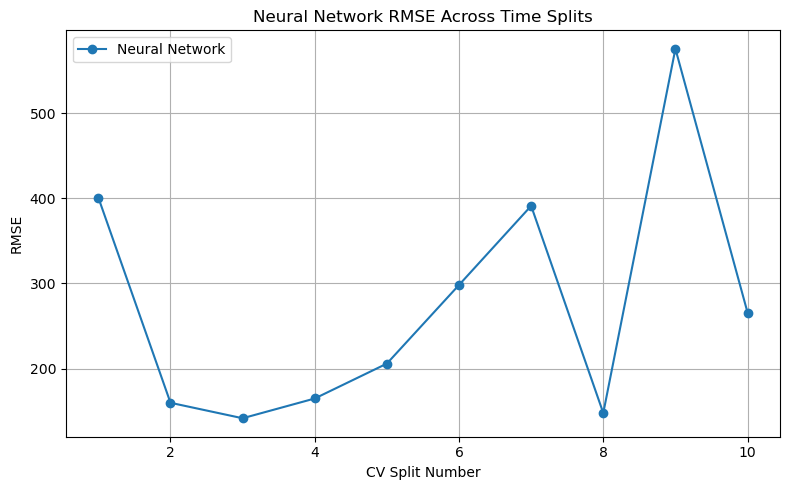

In [48]:
# Force float32 for torch compatibility
float32_transformer = FunctionTransformer(lambda X: X.astype(np.float32), validate=False)

# Define the same preprocessor as before
numeric_cols = X.select_dtypes(include=['float64', 'int']).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Set up time-based CV and storage
tscv = GroupTimeSeriesSplit(n_splits=10, test_size=1)
rmse_per_fold = []

for i, (train_idx, test_idx) in enumerate(tscv.split(X, y, groups=groups), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    nn_pipeline = make_pipeline(
        preprocessor,
        float32_transformer,
        NeuralNetRegressor(hidden_dim=64, epochs=50, batch_size=32, lr=1e-3)
    )

    nn_pipeline.fit(X_train, y_train)
    y_pred = nn_pipeline.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_per_fold.append(rmse)
    print(f"Fold {i} RMSE: {rmse:.2f}")

# Plot RMSE across folds
plt.figure(figsize=(8,5))
plt.plot(range(1, 11), rmse_per_fold, marker='o', label='Neural Network')
plt.xlabel('CV Split Number')
plt.ylabel('RMSE')
plt.title('Neural Network RMSE Across Time Splits')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()